<a href="https://colab.research.google.com/github/Sharan-Babu/ImageDehazingWithCycleGANs/blob/main/RELU_cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1 - Run function cells and mount drive in right folder

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-x4uk_dzg
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-x4uk_dzg
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=8213457f08d6c8cac5edb91d4836e4c88c3838c11298c2c82b5960fa48df50ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-47t7smu3/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot



In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [ ]:
image_shape = (256,256,3)
model = define_discriminator(image_shape)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

In [ ]:
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model       

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10],
                  optimizer=opt)
    return model

In [ ]:
# No need to run after 1st day training

g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
# No need to run after first day training
c_model_AtoBtoA = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoAtoB = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [ ]:
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape,1))
    return X,y

In [ ]:
# Rewrote handier function in the below cell
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'gg_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'gg_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def save_all_models():
    d_model_A.save('d_model_A.h5')
    d_model_B.save('d_model_B.h5')
    c_model_AtoB.save('c_model_A2B.h5')
    c_model_BtoA.save('c_model_B2A.h5')
    g_model_AtoB.save('g_model_AtoB.h5')
    g_model_BtoA.save('g_model_BtoA.h5')
    print('All models were saved in this step.')

In [ ]:
# Rewrote handier function in the below cell
def summarize_performance(step, g_model, trainX, name, n_samples=5):
# select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [ ]:
def my_summarize_performance(step, g_model, trainX, name, n_samples=5):
# select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = 'generated_plot.png'
    psnr = PSNR(X_in[0],X_out[0])
    print(f"PSNR value is {psnr}")
    ssim = measure.compare_ssim(X_in[0], X_out[0],multichannel=True)
    print(f"SSIM value is {ssim}")
    pyplot.savefig(filename1)
    pyplot.close()

In [ ]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,
dataset):
    # define properties of the training run
    n_epochs, n_batch, = 200, 1                                             # I changed n_epochs from 100 to 1 and n_batch to 1 from 150
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
# select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
# generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
# update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA,
            X_realA, X_realB, X_realA])
# update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
# update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB,
            X_realB, X_realA, X_realB])
# update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
# summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2,
            dB_loss1,dB_loss2, g_loss1,g_loss2))
# evaluate the model performance every so often
        if (i+1) % (500) == 0:
# plot A->B translation
            my_summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
# plot B->A translation
            #summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (500) == 0:                                   # changed from (bat_per_epo * 5) to (bat_per_epo * 1)
# save the models
            save_all_models()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive

/content/gdrive


In [ ]:
cd My Drive

/content/gdrive/My Drive


In [ ]:
ls

 1fun.png                                d_model_B.h5
 AA_generated.png                        fun.png
 Adrian.ipynb                            generated_plot.png
 AtoB_generated_plot_000480.png          g_model_AtoB.h5
'bandicam 2020-08-30 18-08-48-328.mp4'   g_model_BtoA.h5
'bandicam 2020-08-30 18-26-53-673.mp4'   HAZE/
 B_generated.jpg                         haze_dataset.npz
 BtoA_generated_plot_000480.png          image.png
 Certificates/                           IMG-20200604-WA0033.jpg
 c_model_A2B.h5                          Interviews/
 c_model_B2A.h5                          model.tflite
'Colab Notebooks'/                      'Project proposal.gdoc'
 Colab_Notebooks/                        RESIDE@
 d_model_A.h5                            Resume.gdoc


In [ ]:
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
d_model_A = load_model('d_model_A.h5',cust)
d_model_B = load_model('d_model_B.h5',cust)
c_model_AtoB = load_model('c_model_A2B.h5',cust)
c_model_BtoA = load_model('c_model_B2A.h5',cust)
g_model_AtoB = load_model('g_model_AtoB.h5',cust)
g_model_BtoA = load_model('g_model_BtoA.h5',cust)
print('All models loaded')

All models loaded


# STEP 2. Load images

In [ ]:
# To be run only the first time this notebook is run - for creating the dataset

from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

def load_images(path, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)

path = 'HAZE/'
# load dataset A
dataA1 = load_images(path + 'hazy/')
dataAB = load_images(path + 'hazy_test/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'GT/')
dataB2 = load_images(path + 'GT_test/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'haze_dataset.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (45, 256, 256, 3)
Loaded dataB:  (45, 256, 256, 3)
Saved dataset:  haze_dataset.npz


Loaded:  (45, 256, 256, 3) (45, 256, 256, 3)


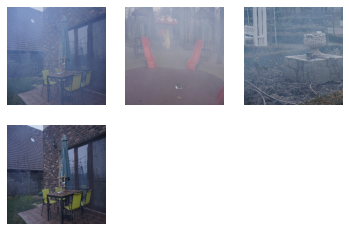

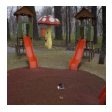

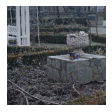

In [ ]:
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load('haze_dataset.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
    pyplot.show()

# STEP 3

In [ ]:
# don't run
# Check epochs in train() before starting

# load image data
dataset = load_real_samples('haze_dataset.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset


Loaded (45, 256, 256, 3) (45, 256, 256, 3)


In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[1.937,1.146] dB[0.681,0.855] g[16.103,18.631]
>2, dA[1.867,1.059] dB[2.617,1.331] g[17.044,16.269]
>3, dA[8.472,1.120] dB[10.443,2.636] g[17.265,16.076]
>4, dA[3.174,3.062] dB[3.868,3.276] g[18.670,18.092]
>5, dA[3.154,1.459] dB[1.513,1.973] g[17.688,16.706]
>6, dA[3.844,2.114] dB[0.871,1.502] g[16.203,17.840]
>7, dA[7.632,1.267] dB[0.779,2.514] g[15.877,14.711]
>8, dA[7.813,1.017] dB[0.739,4.979] g[17.786,14.167]
>9, dA[3.289,2.136] dB[0.798,3.509] g[14.043,12.628]
>10, dA[1.794,1.943] dB[0.592,2.070] g[14.332,14.010]
>11, dA[1.228,0.872] dB[0.697,1.225] g[12.253,12.556]
>12, dA[0.703,0.472] dB[0.591,1.107] g[9.497,9.339]
>13, dA[0.614,1.519] dB[0.554,0.811] g[10.443,12.238]
>14, dA[0.830,0.531] dB[0.516,1.293] g[10.127,10.578]
>15, dA[0.563,2.985] dB[0.389,1.045] g[10.764,14.721]
>16, dA[0.563,1.010] dB[0.443,0.912] g[9.856,10.312]
>17, dA[0.576,0.610] dB[0.559,0.717] g[9.637,9.210]
>18, dA[0.481,0.411] dB[0.619,0.830] g[9.485,9.607]
>19, dA[0.530,0.492] dB[0.270,1.000] g[10.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Streaming output truncated to the last 5000 lines.
>1549, dA[0.003,0.098] dB[0.085,0.064] g[4.640,3.832]
>1550, dA[0.076,0.026] dB[0.090,0.018] g[6.670,8.238]
>1551, dA[0.029,0.145] dB[0.021,0.146] g[4.413,4.438]
>1552, dA[0.016,0.018] dB[0.077,0.102] g[5.053,5.725]
>1553, dA[0.015,0.005] dB[0.027,0.048] g[3.511,4.256]
>1554, dA[0.015,0.026] dB[0.050,0.045] g[4.762,4.934]
>1555, dA[0.006,0.010] dB[0.018,0.016] g[3.882,4.852]
>1556, dA[0.078,0.007] dB[0.038,0.116] g[4.207,4.616]
>1557, dA[0.056,0.007] dB[0.047,0.093] g[5.047,5.273]
>1558, dA[0.006,0.125] dB[0.086,0.014] g[5.435,3.937]
>1559, dA[0.052,0.111] dB[0.107,0.196] g[4.305,5.331]
>1560, dA[0.023,0.104] dB[0.017,0.048] g[4.905,5.194]
>1561, dA[0.012,0.017] dB[0.019,0.045] g[4.406,4.299]
>1562, dA[0.008,0.009] dB[0.019,0.060] g[4.429,4.477]
>1563, dA[0.018,0.026] dB[0.141,0.042] g[6.164,6.395]
>1564, dA[0.045,0.011] dB[0.266,0.094] g[4.896,5.418]
>1565, dA[0.021,0.010] dB[0.118,0.120] g[4.349,4.658]
>1566, dA[0.006,0.030] dB[0.079

KeyboardInterrupt: ignored

In [ ]:
from math import log10, sqrt 
import cv2 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
original = cv2.imread("HAZE/GT/03_outdoor_GT.JPG") 
compressed = cv2.imread("HAZE/hazy/03_outdoor_hazy.JPG") 
value = PSNR(original, compressed) 
print(f"PSNR value is {value} dB")

PSNR value is 27.64639785694837 dB


In [ ]:
from skimage import measure
measure.compare_ssim(original, compressed,multichannel=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


0.7175583632716639

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[0.005,0.002] dB[0.040,0.016] g[4.549,4.877]
>2, dA[0.004,0.003] dB[0.047,0.092] g[4.453,5.425]
>3, dA[0.021,0.002] dB[0.005,0.048] g[4.062,4.361]
>4, dA[0.005,0.002] dB[0.010,0.005] g[4.240,4.141]
>5, dA[0.004,0.002] dB[0.011,0.031] g[3.854,4.291]
>6, dA[0.009,0.002] dB[0.088,0.054] g[4.646,4.678]
>7, dA[0.004,0.003] dB[0.004,0.008] g[3.882,3.833]
>8, dA[0.005,0.002] dB[0.016,0.025] g[4.412,5.104]
>9, dA[0.005,0.002] dB[0.068,0.016] g[3.462,3.178]
>10, dA[0.005,0.002] dB[0.007,0.016] g[3.983,4.296]
>11, dA[0.004,0.002] dB[0.007,0.045] g[3.742,4.163]
>12, dA[0.005,0.002] dB[0.011,0.016] g[3.606,3.354]
>13, dA[0.007,0.002] dB[0.016,0.017] g[3.911,4.191]
>14, dA[0.012,0.002] dB[0.011,0.018] g[3.381,3.263]
>15, dA[0.004,0.002] dB[0.019,0.036] g[4.282,4.220]
>16, dA[0.006,0.003] dB[0.004,0.044] g[4.738,4.885]
>17, dA[0.004,0.003] dB[0.031,0.022] g[3.394,3.140]
>18, dA[0.006,0.002] dB[0.057,0.044] g[4.642,4.706]
>19, dA[0.004,0.002] dB[0.040,0.052] g[4.118,4.258]
>20, dA[0.008,0.004] 

#  PSNR

In [ ]:
pwd

'/content/gdrive/My Drive'

In [ ]:
compressed = cv2.imread("HAZE/GT/39_outdoor_GT.jpg",s)
value = PSNR(A_generated[0],compressed ) 
print(f"PSNR value is {value} dB")

ValueError: ignored

In [ ]:
A_real = select_sample(A_data, 1)
A_generated = g_model_AtoB.predict(A_real)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


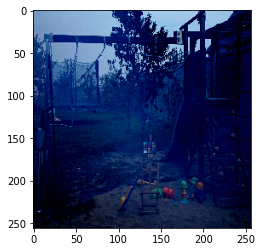

In [ ]:
pyplot.imshow(A_real[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


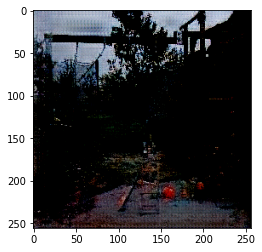

In [ ]:
pyplot.imshow(A_generated[0])

# SSIM

# Inference - Image Translation With Cycle GAN

In [ ]:
# load dataset
A_data, B_data = load_real_samples('haze_dataset.npz')
print('Loaded', A_data.shape, B_data.shape)
cust = {'InstanceNormalization': InstanceNormalization}

Loaded (45, 256, 256, 3) (45, 256, 256, 3)


In [ ]:
from keras.models import load_model
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('gg_model_AtoB_001000.h5', cust)
model_BtoA = load_model('gg_model_BtoA_001000.h5', cust)

In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    return X

In [ ]:
# select input and generate translated images
A_real = select_sample(A_data, 1)
B_generated = g_model_AtoB.predict(A_real)
A_reconstructed = g_model_BtoA.predict(B_generated)

In [ ]:
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    pyplot.savefig("1fun.png")
    titles = ['Real', 'Generated', 'Reconstructed']
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    # plot images row by row
    for i in range(len(images)):
        # define subplot
        
        pyplot.subplot(1, len(images), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        
        # title
        pyplot.title(titles[i])
    pyplot.show()

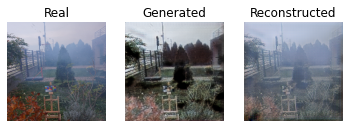

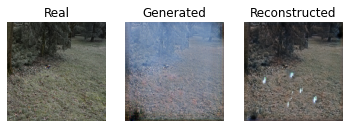

In [ ]:
from numpy import vstack
show_plot(A_real, B_generated, A_reconstructed)    
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated = g_model_BtoA.predict(B_real)
B_reconstructed = g_model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

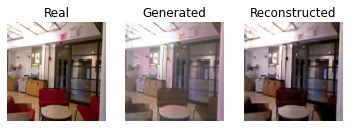

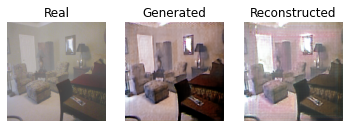

In [ ]:
from numpy import vstack
show_plot(A_real, B_generated, A_reconstructed)    
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)